<a href="https://colab.research.google.com/github/eugenemfu/DUL_HW/blob/main/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 380 (delta 122), reused 96 (delta 66), pack-reused 163
Receiving objects: 100% (380/380), 55.90 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=cef8a1dd6625979e59d950589ace083eaa966bea1d11ee496103a9bf76952da4
  Stored in directory: /tmp/pip-ephem-wheel-cache-0tenyacv/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [3]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

device = 'cuda'

In [4]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)
        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))
        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        features = self.features(x)
        return features


class BYOL_dataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(28),
            transforms.Normalize(0.5, 0.5),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return [self.transforms(self.dataset[i][0]) for _ in range(2)]


class BYOL(nn.Module):
    def __init__(self, hidden_dim=256, latent_dim=128, num_epochs=20, lr=1e-4, tau=0.99):
        super().__init__()
        self.teacher = Net()
        self.student = copy.deepcopy(self.teacher)
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), 
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )
        self.teacher.requires_grad_(False)
        self.num_epochs = num_epochs
        self.lr = lr
        self.tau = tau

    def update(self):
        for t, s in zip(self.teacher.parameters(), self.student.parameters()):
            t.data = self.tau * t.data + (1 - self.tau) * s.data

    def similarity(self, x, y):
        x_ = self.predictor(self.student(x))
        with torch.no_grad():
            y_ = self.teacher(y).detach()
        cos = torch.sum(x_ * y_, dim=1) / (torch.norm(x_, dim=1) * torch.norm(y_, dim=1))
        return 2 * (1 - cos)

    def loss(self, x, y):
        return (self.similarity(x, y) + self.similarity(y, x)).mean()

    def encode(self, x):
        x = x.to(device)
        self.student.eval()
        out = self.student(x)
        self.student.train()
        return out

    def fit(self, train_data):
        opt = Adam(self.parameters(), lr=self.lr)
        dataset = BYOL_dataset(train_data)
        dataloader = DataLoader(dataset, batch_size=256)
        losses = []
        for epoch in tqdm(range(self.num_epochs)):
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                loss = self.loss(x, y)
                opt.zero_grad()
                loss.backward()
                opt.step()
                self.update()
                losses.append(loss.item())
        return np.array(losses)

In [7]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    byol = BYOL(num_epochs=20).to(device)
    losses = byol.fit(train_data)
    return losses, byol.encode

100%|██████████| 20/20 [27:54<00:00, 83.71s/it]


mean classification accuracy=0.5553


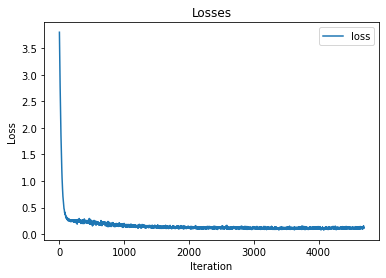

In [8]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)